In [1]:
import copy
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm

from torch.nn import Embedding, LSTM
from torch.nn.utils.rnn import pack_padded_sequence

# Device configuration
cuda = False
if torch.cuda.is_available():
    cuda=True

print(cuda)
torch.set_printoptions(threshold=1000)


True


In [22]:
fake = False

if fake:
    df_benign = pd.read_csv("../checkpoints/URL_LSTM/11-29-2021/Benign/Benign_Samples_29-11-2021_13-13.csv", header=None)
    df_spam = pd.read_csv("../checkpoints/URL_LSTM/11-29-2021/Attack/Spam_Samples_29-11-2021_11-38.csv", header=None, delimiter='\t')
else:
    df_benign = pd.read_csv("../Datasets/URL/FinalDataset/URL/Benign_list_big_final.csv", header=None)

    df1 = pd.read_csv("../Datasets/URL/FinalDataset/URL/spam_dataset.csv", header=None)
    df3 = pd.read_csv("../Datasets/URL/FinalDataset/URL/Malware_dataset.csv", header=None)
    df4 = pd.read_csv("../Datasets/URL/FinalDataset/URL/phishing_dataset.csv", header=None)
    df_spam = pd.concat([df1, df3, df4], ignore_index=True)

df_benign = df_benign.drop_duplicates(keep='first')
benign_urls = np.c_[np.array(df_benign.values), np.zeros_like(np.array(df_benign.values))]
print(benign_urls)
print(benign_urls.shape)

df_spam = df_spam.drop_duplicates(keep='first')
spam_urls = np.c_[np.array(df_spam.values), np.ones_like(np.array(df_spam.values))]
print(spam_urls)
print(spam_urls.shape)

urls = np.append(benign_urls, spam_urls, axis=0)
print(urls.shape)

[['http://1337x.to/torrent/1048648/American-Sniper-2014-MD-iTALiAN-DVDSCR-X264-BST-MT/'
  0]
 ['http://1337x.to/torrent/1110018/Blackhat-2015-RUSSIAN-720p-WEB-DL-DD5-1-H264-RUFGT/'
  0]
 ['http://1337x.to/torrent/1122940/Blackhat-2015-x264-1080p-WEB-DL-eng-nl-subs-sharky/'
  0]
 ...
 ['https://lastpass.com/signup2.php?ac=1&from_uri=%2Fsignup2.php%3Fac%3D1%26from_uri%3D%252Fsignup2.php%253Fac%253D1%2526from_uri%253D%25252Fsignup2.php%25253Fac%25253D1%252526from_uri%25253D%2525252Fsignup2.php%2525253Fac%2525253D1%25252526from_uri%2525253D%252525252Fsignup2.php%252525253Fac%252525253D1%2525252526from_uri%252525253D%25252525252Fsignup2.php%25252525253Fac%25252525253D1%252525252526from_uri%25252525253D%2525252525252Fsignup2.php%2525252525253Fac%2525252525253D1%25252525252526from_uri%2525252525253D%252525252525252Fsignup2.php%252525252525253Fac%252525252525253D1%2525252525252526from_uri%252525252525253D%25252525252525252Fsignup2.php%25252525252525253Fac%25252525252525253D1%252525252525252526

In [23]:
allURL = ''.join(urls[:,0])
chars = tuple(['<pad>'] + sorted(set(allURL))) #find unique characters
print(chars)

int2char = dict(enumerate(chars)) #go over each unique char in the set and assign an int
char2int = {ch: ii for ii, ch in int2char.items()} #creates dictionary that maps char to integer (reverse of above)

encoded = []
for url in urls:
    encoded.append([char2int[ch] for ch in url[0]])


X = np.array(encoded)
y = np.array(urls[:,1])

print(X.shape, y.shape)
print(X[0], y[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=12)

('<pad>', ' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x8d', '¸', 'ä', 'å', 'ø', 'Š', 'ˆ')
(59946,) (59946,)
[67, 79, 79, 75, 26, 15, 15, 17, 19, 19, 23, 83, 14, 79, 74, 15, 79, 74, 77, 77, 64, 73, 79, 15, 17, 16, 20, 24, 22, 20, 24, 15, 31, 72, 64, 77, 68, 62, 60, 73, 13, 49, 73, 68, 75, 64, 77, 13, 18, 16, 17, 20, 13, 43, 34, 13, 68, 50, 31, 42, 68, 31, 44, 13, 34, 52, 34, 49, 33, 48, 13, 54, 18, 22, 20, 13, 32, 49, 50, 13, 43, 50, 15] 0


C:\Users\Spencer\AppData\Local\Temp\ipykernel_25376\4043335881.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(encoded)


In [14]:
def get_batches(X, y, batch_size):

    batches_X, batches_y, seq_lengths = [], [], []

    for i in tqdm(range(int(len(X)/batch_size))):  #number of even batches
        batch_X, batch_y, seq_lengths_batch = [], [], []

        for r in range(i*batch_size, (i+1)*batch_size):
            seq_lengths_batch.append(len(X[r]))
            batch_X.append(X[r])
            batch_y.append(y[r])

        maxLen =  max(seq_lengths_batch)

        text_in = torch.zeros((batch_size, maxLen))
        target = torch.tensor(batch_y)

        for r in range(batch_size):
            for c in range(len(batch_X[r])):
                text_in[r][c] = batch_X[r][c]

        seq_lengths_batch, perm_idx = torch.tensor(seq_lengths_batch).sort(0, descending=True) #sort batch with longest sequence at the top
        text_in = text_in[perm_idx]
        target = target[perm_idx]

        batches_X.append(text_in.long())
        batches_y.append(target.float())
        seq_lengths.append(seq_lengths_batch.long())

    return batches_X, batches_y, seq_lengths

In [16]:
class CharRNN(nn.Module):

    def __init__(self, tokens, hidden_size=256, num_layers=2, lr=0.01):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lr = lr
        self.input_size = len(tokens)
        self.output_size = 1 #since its binary classification

        #create character dictionary
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in int2char.items()}

        #define network
        self.embed = Embedding(self.input_size, hidden_size, padding_idx=0)
        self.lstm = LSTM(hidden_size, hidden_size, num_layers, batch_first=True )
        #self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, self.output_size)

        self.init_weights()

    def forward(self, x, x_lengths):
        embedded_input = self.embed(x)
        packed_input = pack_padded_sequence(embedded_input, x_lengths.cpu().numpy(), batch_first=True)
        packed_out, (hidden_state, cell_state) = self.lstm(packed_input)

        out = self.fc(hidden_state)
        return out

    def predict(self, inputs, seq_lengths):

        if cuda:
            self.cuda()

        h = self.forward(inputs, seq_lengths)
        p = torch.sigmoid(h[-1,:,:].squeeze())

        if cuda:
            p = p.cpu()

        return p

    #Initialize weights for fully connected layer
    def init_weights(self):

        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)

# Calculate performance measures
def compute_performance(yhat, y, pos_cutoff):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat >= pos_cutoff, y == 1).numpy())
    tn = sum(np.logical_and(yhat < pos_cutoff, y == 0).numpy())
    fp = sum(np.logical_and(yhat >= pos_cutoff, y == 0).numpy())
    fn = sum(np.logical_and(yhat < pos_cutoff, y == 1).numpy())

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")

    acc = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    sensitivity = recall
    specificity = tn / (fp + tn)

    # Print results
    print("Accuracy: ",acc," Recall: ",recall," Precision: ",precision,
          " Sensitivity: ",sensitivity," Specificity: ",specificity)


In [19]:
def train(net, X, y, cuda=False, epochs=10, batch_size=10, lr=0.001, clip=5, early_stop=10):

    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    if cuda:
        net.cuda()

    lowest_val_loss = np.inf
    train_losses, val_losses =[], []
    lowest_val_epoch, epochs_wo_improvement = 0, 0
    best_model = copy.deepcopy(net.state_dict())

    print("\nMaking Training and Validation Batches")
    # create training and validation batches
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=12)
    train_inputs, train_targets, train_seq_lengths = get_batches(X_train, y_train, batch_size)
    val_inputs, val_targets, val_seq_lengths = get_batches(X_val, y_val, batch_size)

    print("\nTraining Start\n")
    for e in range(epochs):

        net.train()
        epoch_loss = 0

        for b in tqdm(range(len(train_inputs))):
            if cuda:
                input, target, seq_length = train_inputs[b].cuda(), train_targets[b].cuda(), train_seq_lengths[b].cuda()
            else:
                input, target, seq_length = train_inputs[b], train_targets[b], train_seq_lengths[b]

            net.zero_grad(set_to_none=None)
            h = net.forward(input, seq_length)
            loss = criterion(h[-1,:,:].squeeze(), target)
            loss.backward()
            opt.step()
            epoch_loss+=loss

        train_losses.append(epoch_loss.item()/len(train_inputs))

        #VALIDATION
        with torch.no_grad():
            net.eval()
            net.zero_grad(set_to_none=None)
            val_loss = 0
            val_preds, val_targets_list = [], []

            for vb in tqdm(range(len(val_inputs))):
                if cuda:
                    val_input, val_target, val_seq_length = val_inputs[vb].cuda(), val_targets[vb].cuda(), val_seq_lengths[vb].cuda()

                val_h = net.forward(val_input, val_seq_length)
                val_preds+=val_h[-1,:,:].squeeze()
                val_targets_list+=val_target
                val_loss += criterion(val_h[-1,:,:].squeeze(), val_target)

        val_loss = val_loss.item()/len(val_inputs)
        val_losses.append(val_loss)

        if val_loss <= lowest_val_loss:
            best_model = copy.deepcopy(net.state_dict())
            lowest_val_loss = val_loss
            lowest_val_epoch=e
            epochs_wo_improvement=0
        else:
            epochs_wo_improvement+=1

        if epochs_wo_improvement>=early_stop:
            print("Early Stop no improvement in validation loss in "+str(early_stop)+" validation steps")
            break

        print("Epoch: {}/{}...".format(e, epochs),
              "Loss: {:.4f}...".format(train_losses[-1]),
              "Val Loss: {:.4f}".format(val_losses[-1]),)

        compute_performance(torch.sigmoid(torch.Tensor(val_preds)), torch.Tensor(val_targets_list), 0.5)

    print("Lowest Validation Loss: "+str(lowest_val_loss.item()))

    net.load_state_dict(best_model)
    run_ID = datetime.now().strftime("%d-%m-%Y_%H-%M")
    torch.save({'model_state_dict': best_model}, 'C:/Users/Spencer/Documents/pytorch/checkpoints/URL_LSTM/'+str(run_ID)+'_E_'+str(lowest_val_epoch)+'_VL_'+str(round(lowest_val_loss.item(), 4))+'.pt')

    df = pd.DataFrame(zip(train_losses, val_losses), columns=["Train Loss", "Validation Loss"])
    print(df)
    df.to_csv('../checkpoints/URL_LSTM/'+str(run_ID)+'_E-'+str(lowest_val_epoch)+'_VL-{:.4f}'.format(lowest_val_loss)+'.csv')

    #plot losses
    fig, ax = plt.subplots(dpi = 120)
    ax.set_title("Training and Validation Loss")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.plot(np.linspace(0, len(train_losses), len(train_losses)),train_losses, 'r', label='Training Loss' )
    ax.plot(np.linspace(0, len(val_losses), len(val_losses)),val_losses, 'b', label='Validation Loss' )
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    plt.show()
    fig.savefig('../checkpoints/URL_LSTM/'+str(run_ID)+'_E-'+str(lowest_val_epoch)+'_VL-{:.4f}'.format(lowest_val_loss)+'.png')
    plt.close(fig)

    return net

  1%|          | 2/358 [00:00<00:25, 14.08it/s]

CharRNN(
  (embed): Embedding(97, 512, padding_idx=0)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

Making Training and Validation Batches


  0%|          | 0/358 [00:00<?, ?it/s]


Training Start



100%|██████████| 39/39 [00:01<00:00, 34.80it/s]


Epoch: 0/50... Loss: 0.1786... Val Loss: 0.0737


  0%|          | 1/358 [00:00<00:53,  6.73it/s]

tp: 1988 tn: 2906 fp: 29 fn: 69
Accuracy:  0.9803685897435898  Recall:  0.966456003889159  Precision:  0.9856222112047596  Sensitivity:  0.966456003889159  Specificity:  0.9901192504258943


100%|██████████| 39/39 [00:01<00:00, 35.89it/s]


Epoch: 1/50... Loss: 0.0569... Val Loss: 0.0707


  0%|          | 1/358 [00:00<00:51,  6.97it/s]

tp: 1981 tn: 2915 fp: 20 fn: 76
Accuracy:  0.9807692307692307  Recall:  0.9630529897909577  Precision:  0.9900049975012494  Sensitivity:  0.9630529897909577  Specificity:  0.9931856899488927


100%|██████████| 39/39 [00:01<00:00, 36.51it/s]


Epoch: 2/50... Loss: 0.0325... Val Loss: 0.0330


  0%|          | 1/358 [00:00<00:51,  6.94it/s]

tp: 2029 tn: 2921 fp: 14 fn: 28
Accuracy:  0.9915865384615384  Recall:  0.986387943607195  Precision:  0.9931473323543808  Sensitivity:  0.986387943607195  Specificity:  0.9952299829642248


100%|██████████| 39/39 [00:01<00:00, 36.22it/s]


Epoch: 3/50... Loss: 0.0190... Val Loss: 0.0254


  0%|          | 1/358 [00:00<00:51,  6.92it/s]

tp: 2044 tn: 2919 fp: 16 fn: 13
Accuracy:  0.9941907051282052  Recall:  0.9936801166747691  Precision:  0.9922330097087378  Sensitivity:  0.9936801166747691  Specificity:  0.9945485519591142


100%|██████████| 39/39 [00:01<00:00, 35.42it/s]


Epoch: 4/50... Loss: 0.0137... Val Loss: 0.0275


  0%|          | 1/358 [00:00<00:51,  6.94it/s]

tp: 2042 tn: 2910 fp: 25 fn: 15
Accuracy:  0.9919871794871795  Recall:  0.9927078269324259  Precision:  0.9879051765844219  Sensitivity:  0.9927078269324259  Specificity:  0.9914821124361158


100%|██████████| 39/39 [00:01<00:00, 35.99it/s]


Epoch: 5/50... Loss: 0.0097... Val Loss: 0.0167


  0%|          | 1/358 [00:00<00:52,  6.80it/s]

tp: 2052 tn: 2922 fp: 13 fn: 5
Accuracy:  0.9963942307692307  Recall:  0.997569275644142  Precision:  0.9937046004842615  Sensitivity:  0.997569275644142  Specificity:  0.9955706984667803


100%|██████████| 39/39 [00:01<00:00, 36.34it/s]


Epoch: 6/50... Loss: 0.0082... Val Loss: 0.0159


  0%|          | 1/358 [00:00<00:51,  6.92it/s]

tp: 2052 tn: 2922 fp: 13 fn: 5
Accuracy:  0.9963942307692307  Recall:  0.997569275644142  Precision:  0.9937046004842615  Sensitivity:  0.997569275644142  Specificity:  0.9955706984667803


100%|██████████| 39/39 [00:01<00:00, 36.26it/s]


Epoch: 7/50... Loss: 0.0025... Val Loss: 0.0217


  0%|          | 1/358 [00:00<00:51,  6.94it/s]

tp: 2042 tn: 2928 fp: 7 fn: 15
Accuracy:  0.9955929487179487  Recall:  0.9927078269324259  Precision:  0.9965836993655441  Sensitivity:  0.9927078269324259  Specificity:  0.9976149914821124


100%|██████████| 39/39 [00:01<00:00, 36.31it/s]


Epoch: 8/50... Loss: 0.0054... Val Loss: 0.0179


  0%|          | 1/358 [00:00<00:51,  6.92it/s]

tp: 2055 tn: 2917 fp: 18 fn: 2
Accuracy:  0.9959935897435898  Recall:  0.9990277102576568  Precision:  0.9913169319826338  Sensitivity:  0.9990277102576568  Specificity:  0.9938671209540034


100%|██████████| 39/39 [00:01<00:00, 36.02it/s]


Epoch: 9/50... Loss: 0.0091... Val Loss: 0.0144


  0%|          | 1/358 [00:00<00:52,  6.82it/s]

tp: 2052 tn: 2923 fp: 12 fn: 5
Accuracy:  0.9965945512820513  Recall:  0.997569275644142  Precision:  0.9941860465116279  Sensitivity:  0.997569275644142  Specificity:  0.9959114139693356


100%|██████████| 39/39 [00:01<00:00, 35.48it/s]


Epoch: 10/50... Loss: 0.0035... Val Loss: 0.0144


  0%|          | 1/358 [00:00<00:56,  6.33it/s]

tp: 2049 tn: 2925 fp: 10 fn: 8
Accuracy:  0.9963942307692307  Recall:  0.9961108410306271  Precision:  0.9951432734337057  Sensitivity:  0.9961108410306271  Specificity:  0.9965928449744463


100%|██████████| 39/39 [00:01<00:00, 36.31it/s]


Epoch: 11/50... Loss: 0.0041... Val Loss: 0.0247


  0%|          | 1/358 [00:00<00:53,  6.71it/s]

tp: 2046 tn: 2912 fp: 23 fn: 11
Accuracy:  0.9931891025641025  Recall:  0.9946524064171123  Precision:  0.9888835186080231  Sensitivity:  0.9946524064171123  Specificity:  0.9921635434412266


100%|██████████| 39/39 [00:01<00:00, 35.68it/s]


Epoch: 12/50... Loss: 0.0022... Val Loss: 0.0181


  0%|          | 1/358 [00:00<00:52,  6.85it/s]

tp: 2044 tn: 2931 fp: 4 fn: 13
Accuracy:  0.9965945512820513  Recall:  0.9936801166747691  Precision:  0.998046875  Sensitivity:  0.9936801166747691  Specificity:  0.9986371379897785


100%|██████████| 39/39 [00:01<00:00, 36.26it/s]


Early Stop no improvement in validation loss in 3 validation steps
Lowest Validation Loss: 0.5607379674911499
    Train Loss  Validation Loss
0     0.178555         0.073744
1     0.056885         0.070667
2     0.032463         0.032951
3     0.018979         0.025408
4     0.013741         0.027525
5     0.009718         0.016683
6     0.008219         0.015915
7     0.002507         0.021675
8     0.005354         0.017877
9     0.009145         0.014398
10    0.003502         0.014378
11    0.004129         0.024724
12    0.002201         0.018079
13    0.003156         0.028818


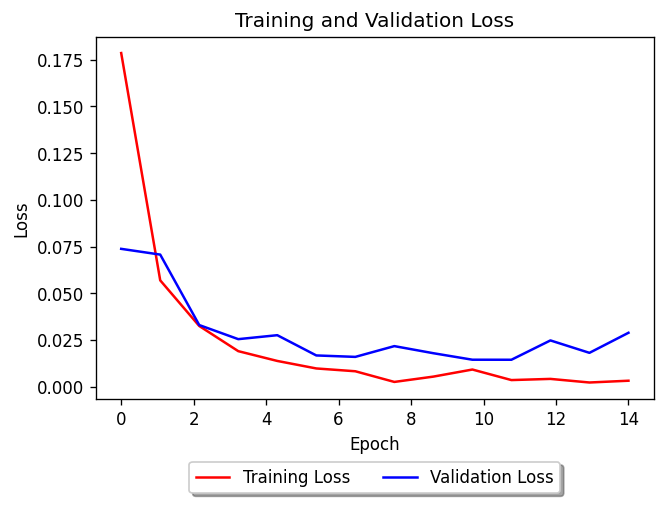

In [24]:
net = CharRNN(chars, hidden_size=512, num_layers=2)
print(net)

model = train(net, X_train, y_train, epochs=50, batch_size=128, lr=0.001, cuda=cuda, early_stop=3)


In [13]:
# load checkpoint
model = CharRNN(chars, hidden_size=512, num_layers=2)

checkpoint = torch.load('../checkpoints/URL_LSTM/11-29-2021/Classifier/Fake/29-11-2021_14-42_E_6_VL_0.5374.pt')
model.load_state_dict(checkpoint['model_state_dict'])


RuntimeError: Error(s) in loading state_dict for CharRNN:
	size mismatch for embed.weight: copying a param with shape torch.Size([93, 512]) from checkpoint, the shape in current model is torch.Size([98, 512]).

100%|██████████| 104/104 [00:02<00:00, 41.29it/s]


tp: 5944 tn: 7312 fp: 25 fn: 31
Accuracy:  0.9957932692307693  Recall:  0.9948117154811715  Precision:  0.9958116937510471  Sensitivity:  0.9948117154811715  Specificity:  0.9965926127845168
[[7312   25]
 [  31 5944]]


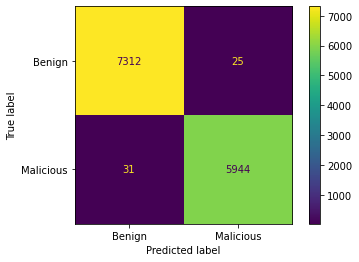

In [26]:
test_inputs, test_targets, test_seq_lengths = get_batches(X_test, y_test, 128)
predictions, actuals = [], []
model.eval()
for i in tqdm(range(len(test_inputs))):

    if cuda:
        test_input_batch, test_target_batch, test_seq_length_batch = test_inputs[i].cuda(), test_targets[i], test_seq_lengths[i].cuda()

    predictions+= (model.predict(test_input_batch, test_seq_length_batch)).detach().cpu()
    actuals+=test_target_batch

compute_performance(torch.tensor(np.array(predictions)), torch.tensor(np.array(actuals)), 0.5)
print(confusion_matrix(actuals, np.round(predictions)))
disp = ConfusionMatrixDisplay(confusion_matrix(actuals, np.round(predictions), labels=[0,1]), display_labels=['Benign', 'Malicious'])
disp.plot()
